In [1]:
from scipy import io
import numpy as np

import matplotlib.pyplot as plt

plt.style.use("seaborn")

from sklearn.decomposition import PCA

from sklearn.linear_model import Ridge, LinearRegression

from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

from scipy.linalg import cholesky

from math import inf

In [2]:
data = io.loadmat("burgers_data_R10.mat")

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

# Problem

We consider the following initial value problem 

\begin{align}
    \frac{\partial u}{\partial t } + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \quad &x \in (0,1), t \in (0,1 ] \\
    u(x, 0) = u_0(x), \quad &x \in (0,1)
\end{align}

and aim to learn the operator 

\begin{equation}
    \mathcal{G}: u_0(x) \mapsto u(x,1).
\end{equation}

The initial condition is sampled from $\mu = \mathcal{GP}(0, 625(-\Delta  + 25I )^{-2}))$. What does this mean?

I'm assuming that this means that if $X$ is a GP defined to be the solution of 
$$ 
(-\Delta  + \tau I )^{d}X = \dot{W}
$$
where $\dot{W}$ is white noise. Then

$$ 
Cov(X(f), X(g)) = \langle f, (-\Delta  + \tau I )^{-d} g\rangle_{L^2}
$$

In our case, $f \sim \mu$ is equivalent to

$$
X(f) \sim \mathcal{N}\Bigg(0, 625\int f(-\Delta  + 25I )^{-2} f \Bigg)
$$
and 
$$
Cov(X(f), X(g)) = \int  f\Big( (625(-\Delta  + 25I )^{-2} g\Big) = 625 \int (-\Delta  + 25I )^{-1} f (-\Delta  + 25I )^{-1} g 
$$


Note that
$$ 
\langle f, (-\Delta)^{d} g\rangle = \langle f, g\rangle_{H^d_0}
$$
Hence the RKHS (Cameron Martin space) of the measure $\mu$ is $H^d$ whereas the draws belong to $H^{d-1}$ (one less than the RKHS). Hence the draws belong to $H^1$.


We will therefore use the Matern kernel with $\nu =0.5
$ (Exponential kernel) as our RKHS.

## Importing the data

In [4]:
def get_data(ntrain, ntest):
    sub_x = 2 ** 6
    sub_y = 2 ** 6

    # Data is of the shape (number of samples = 2048, grid size = 2^13)
    data = io.loadmat("burgers_data_R10.mat")
    x_data = data["a"][:, ::sub_x].astype(np.float64)
    y_data = data["u"][:, ::sub_y].astype(np.float64)
    x_branch_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_branch_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]
    
        
    s = 2 ** 13 // sub_y  # total grid size divided by the subsampling rate
    grid = np.linspace(0, 1, num=2 ** 13)[::sub_y, None]
    
    return x_branch_train, y_train, x_branch_test, y_test, grid


    x_train = (x_branch_train, grid)
    x_test = (x_branch_test, grid)
    return x_train, y_train, x_test, y_test

In [5]:
x, y, x_test, y_test, grid = get_data(1000, 200)

In [6]:
x.shape, x_test.shape

((1000, 128), (200, 128))

Text(0, 0.5, '$u_0(x)$')

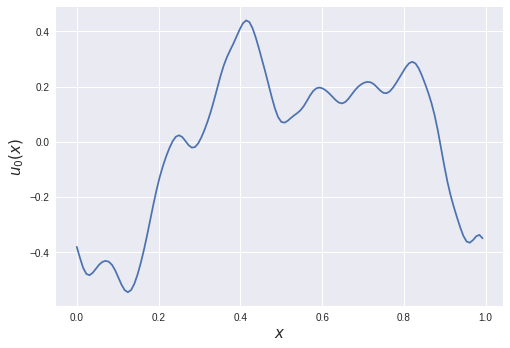

In [7]:
idx = 2

plt.figure()
plt.plot(grid, x[idx])
plt.xlabel(r'$x$', size= 15)
plt.ylabel(r'$u_0(x)$', size= 15)

# Fitting the GP: no cholesky

In [8]:
def train_test(x_train, x_test, y_train, y_test):
    kernel = Matern(nu = 2.5)
    gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = True, random_state= 1172023) 
    
    gp.fit(x_train, y_train)
    pred= gp.predict(x_test)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, gp

In [9]:

pred, GP = train_test(x, x_test, y, y_test)
pred_train = GP.predict(x)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e_train = np.mean(np.linalg.norm(pred_train - y, axis = -1)/np.linalg.norm(y, axis = -1))

In [10]:
e, GP.kernel_

(0.029101152889293606, Matern(length_scale=13.3, nu=2.5))

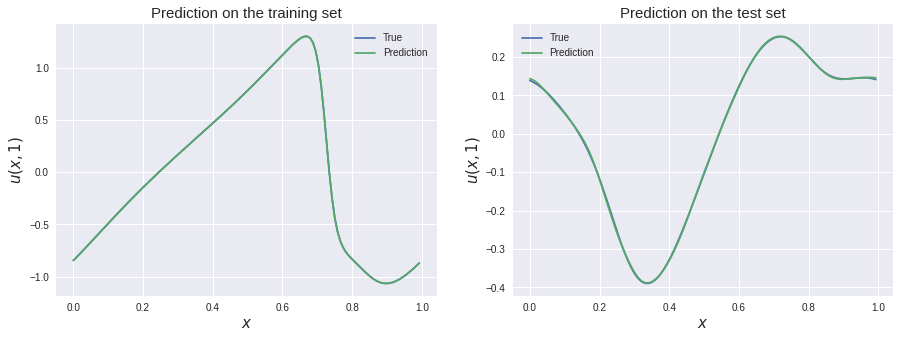

In [11]:
idx = 15
i = 0

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y[idx], label = "True")
ax1.plot(grid, pred_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()

# Fitting the GP: pre-conditioning by cholesky factors

To do this we precompute:

$$ 
K(X,X)^{-1} = L_K L_K^* \\
G(X,X)^{-1} = L_G L_G^*.
$$
We are using the convention where $L_K, L_G$ are **lower triangular**.
Here $K$ and $G$ are exponential kernels (which lenthscale should be used?).

Moreover $X$ is a grid of the interval $[0,1]$ of dimension 128.

## Computing the cholesky factors

In [12]:
data = io.loadmat("burgers_data_R10.mat")

In [31]:
kernel_u = Matern(nu = 1.5, length_scale = 0.5) 
kernel_v = Matern(nu = 1.5, length_scale = 0.5)
#kernel = RBF()
gp_u = GaussianProcessRegressor(kernel_u, alpha = 1e-10)
gp_v = GaussianProcessRegressor(kernel_v, alpha = 1e-10)

In [32]:
K = kernel_u.__call__(grid)
G = kernel_v.__call__(grid)

L_K = cholesky(K, lower=False)
L_G = cholesky(G, lower = False)

tau = 0
L_K_inv = np.linalg.inv(L_K + tau*1e-10*np.eye(K.shape[0]))
L_G_inv = np.linalg.inv(L_G + tau*1e-10*np.eye(K.shape[0]))

L_K, L_K_inv

(array([[1.        , 0.99964024, 0.99858662, ..., 0.14874569, 0.14566761,
         0.14264785],
        [0.        , 0.02682136, 0.05267719, ..., 0.11896649, 0.11671611,
         0.11450108],
        [0.        , 0.        , 0.0070626 , ..., 0.03939907, 0.03865673,
         0.03792595],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00683688, 0.01514041,
         0.02299559],
        [0.        , 0.        , 0.        , ..., 0.        , 0.00683688,
         0.01514041],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00683688]]),
 array([[ 1.00000000e+00, -3.72703088e+01,  1.36593918e+02, ...,
         -1.08016162e-09,  1.35753181e-09, -1.16503714e-09],
        [ 0.00000000e+00,  3.72837219e+01, -2.78084709e+02, ...,
          3.14170540e-09, -4.08556407e-09,  4.11131529e-09],
        [ 0.00000000e+00,  0.00000000e+00,  1.41590870e+02, ...,
         -3.75419231e-09,  5.09181558e-09, -6.03454788e-09],
        ...,
        [ 0.000000

In [33]:
K@(L_K_inv@L_K_inv.T)

array([[ 1.00000000e+00,  3.48139010e-12,  7.34911662e-11, ...,
         9.09494702e-13,  3.63797881e-12, -4.54747351e-13],
       [ 1.91320899e-11,  1.00000000e+00,  4.95980597e-11, ...,
         3.63797881e-12,  3.63797881e-12, -1.36424205e-12],
       [ 1.65519524e-11, -8.36201271e-12,  1.00000000e+00, ...,
        -9.09494702e-13,  4.54747351e-12, -1.36424205e-12],
       ...,
       [ 3.65898802e-12, -3.77229688e-12,  1.74279610e-11, ...,
         1.00000000e+00, -2.91038305e-11,  1.09139364e-11],
       [ 4.64832411e-12, -4.37787773e-12,  1.17763720e-11, ...,
        -1.45519152e-11,  1.00000000e+00, -3.63797881e-12],
       [ 3.62997354e-12, -3.36702236e-12,  1.54104975e-11, ...,
         7.27595761e-12,  3.63797881e-11,  1.00000000e+00]])

In [34]:
x_train = []
for i in range(x.shape[0]):
    x_train.append(L_K_inv.T@x[i])
x_train = np.array(x_train)

y_train = []
for i in range(y.shape[0]):
    y_train.append(L_G_inv.T@y[i])
y_train = np.array(y_train)


x_val = []
for i in range(x_test.shape[0]):
    x_val.append(L_K_inv.T@x_test[i])
x_val = np.array(x_val)

y_val = []
for i in range(y_test.shape[0]):
    y_val.append(L_G_inv.T@y_test[i])
y_val = np.array(y_val)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1000, 128), (200, 128), (1000, 128), (200, 128))

In [35]:
idx = 0
np.mean((K@(L_K_inv@x_train[idx]) - x[idx])**2), np.mean((K@(L_K_inv@x_val[idx]) - x_test[idx])**2)

(2.641196881211118e-25, 3.736984039280565e-25)

In [36]:
# Recovering the pointwise measurements

u_recov = []
for i in range(x.shape[0]):
    u_recov.append(K@L_K_inv@x_train[i])
u_recov = np.array(u_recov)

    
v_recov = []
for i in range(y.shape[0]):
    v_recov.append(G@L_G_inv@pred_train[i])
v_recov = np.array(v_recov)

e_u = np.mean(np.linalg.norm(u_recov - x, axis = -1)/np.linalg.norm(x, axis = -1))
e_v = np.mean(np.linalg.norm(v_recov - y, axis = -1)/np.linalg.norm(y, axis = -1))

print(e_u, e_v)

u_recov = []
for i in range(x_test.shape[0]):
    u_recov.append(K@L_K_inv@x_val[i])
u_recov = np.array(u_recov)

    
v_recov = []
for i in range(y_test.shape[0]):
    v_recov.append(G@L_G_inv@y_val[i])
v_recov = np.array(v_recov)

e_u = np.mean(np.linalg.norm(u_recov - x_test, axis = -1)/np.linalg.norm(x_test, axis = -1))
e_v = np.mean(np.linalg.norm(v_recov - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

print(e_u, e_v)

5.369792394597202e-13 0.7762378347855656
5.265319135217148e-13 2.369783490211566e-13


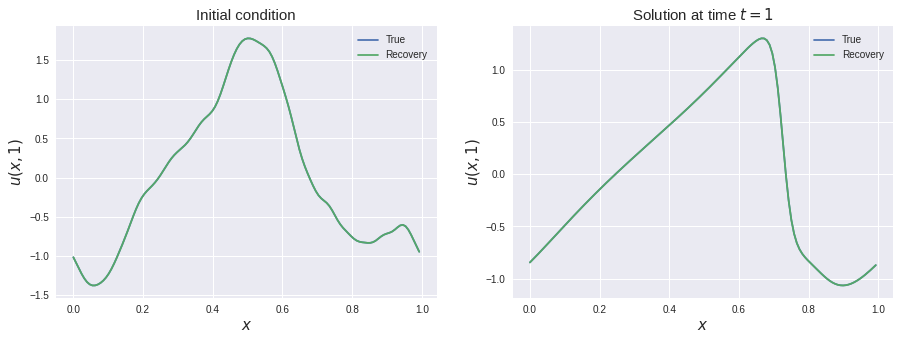

In [37]:
# Computing the optimal recovery 
idx = 15
recov_u = K@L_K_inv@x_train[idx]
recov_v = G@L_G_inv@y_train[idx]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, x[idx], label = "True")
ax1.plot(grid, recov_u, label = "Recovery")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Initial condition", size = 15)
ax1.legend()

ax2.plot(grid, y[idx],  label = "True")
ax2.plot(grid, recov_v,  label = "Recovery")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Solution at time $t=1$", size = 15)
ax2.legend()

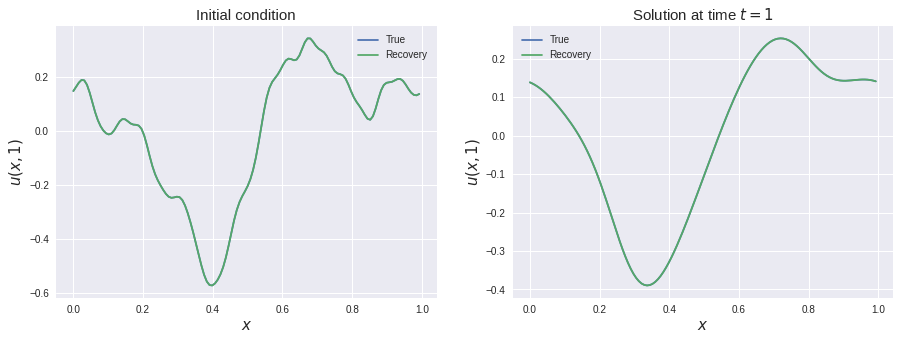

In [38]:
# Computing the optimal recovery on a test point
idx = 15
recov_u = K@(L_K_inv@x_val[idx])
recov_v = G@L_G_inv@y_val[idx]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, x_test[idx], label = "True")
ax1.plot(grid, recov_u, label = "Recovery")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Initial condition", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, recov_v,  label = "Recovery")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Solution at time $t=1$", size = 15)
ax2.legend()

## Fitting the gp on the pre-conditioned measurements

In [49]:
def train_test(x_train, x_test, y_train, y_test):
    kernel = Matern(nu = 2.5, length_scale = 15.0)
    gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = True, n_restarts_optimizer =5) 
    
    gp.fit(x_train, y_train)
    pred= gp.predict(x_test)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)
    print(gp.kernel_)
    return pred, gp

In [50]:
pred, gp = train_test(x_train, x_val, y_train, y_val)
pred_train = gp.predict(x_train)
e = np.mean(np.linalg.norm(pred - y_val, axis = -1)/np.linalg.norm(y_val, axis = -1))
e_train = np.mean(np.linalg.norm(pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1))

Matern(length_scale=5.53, nu=2.5)


In [51]:
e, e_train, gp.kernel_

(0.9990290286247483, 1.1259245766862044e-10, Matern(length_scale=5.53, nu=2.5))

In [52]:
e, e_train

(0.9990290286247483, 1.1259245766862044e-10)

In [53]:
gp.kernel_

Matern(length_scale=5.53, nu=2.5)

In [54]:
# Recovering the pointwise measurements

pred_point = []
for i in range(y_test.shape[0]):
    pred_point.append(G@L_G_inv@pred[i])
    
pred_point = np.array(pred_point)
    
pred_point_train = []
for i in range(x.shape[0]):
    pred_point_train.append(G@L_G_inv@pred_train[i])
pred_point_train = np.array(pred_point_train)

e = np.mean(np.linalg.norm(pred_point - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e_train = np.mean(np.linalg.norm(pred_point_train - y, axis = -1)/np.linalg.norm(y, axis = -1))

e, e_train

(0.549140654692988, 6.069836002193915e-11)

In [55]:
e, e_train

(0.549140654692988, 6.069836002193915e-11)

In [56]:
e, e_train

(0.549140654692988, 6.069836002193915e-11)

In [57]:
e = np.mean(np.linalg.norm(pred_point - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e_train = np.mean(np.linalg.norm(pred_point_train - y, axis = -1)/np.linalg.norm(y, axis = -1))

e, e_train

(0.549140654692988, 6.069836002193915e-11)

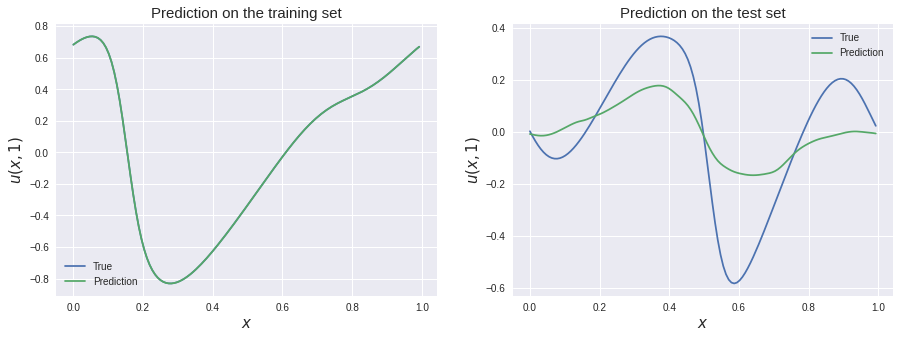

In [58]:
idx = 0

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y[idx], label = "True")
ax1.plot(grid, pred_point_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred_point[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()